##  <font color='273469'> Product Trend Analysis: Amazon Reviews in the Personal Care Vertical <font><a class='anchor' id='top'></a>
 ===== </br>
 **Author:** Stephanie Lo

### <font color='256D85'>Table of contents<font><a class='anchor' id='top'></a>

1. [Introduction to the notebook](#1)</br>
2. [Loading Finalized Data](#2)</br>
    a.[Splitting data into train and test](#2.a)</br>
    b.[Setting up the Column Transformer](#2.b)</br>
3. [Modelling](#3)</br>
    a.[Logistic Regression](#3.a)</br>
    b.[Support Vector Machine](#3.b)</br>
    c.[Random Forest](#3.c)</br>
    d.[XGBoost](#3.d)</br>
4. [Model Evaluation](#4)</br>
    a.[Deciding between Random Forest and XGBoost](#4.a)</br>
    b.[Random Forest Interpretability](#4.b)</br>
    c.[Applying the machine learning algorithm with product description](#4.c)</br>
    d.[The Final Model](#4.d)</br>
5. [Conclusion to the notebook](#5)</br>
    a.[Final Thoughts](#5.a)

## <font color='256D85'> Introduction to this notebook  <font>  <a id="1"></a>

This notebook will perform the modelling process and model evaluation in order to choose the best model for our project trend searcher. To conclude, we will evaluate what the next steps would be to implement this model in practice. Please note that this notebook was run with an Amazon Sagemaker instance so there will be some markdown speaking to this process. 

##  <font color='256D85'> Loading Finalized Data <font> <a id="2"></a>

In this section we will be reading in the finalized data set that we worked on over the past two notebooks. This contains the combined dataset of both product metadata and review data.

In [1]:
#importing base packages
import numpy as np
import pandas as pd
import os 
import joblib
from tempfile import mkdtemp

#loading in data visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#loading in amazon-specific package
import boto3 

In [80]:
#Setting figure size & background for the notebook
plt.rcParams['figure.figsize'] = (8.0, 6.0)
sns.set_theme(style="darkgrid")

The code below is optional if you wanted to access the file from the S3 bucket, however for this notebook we will read in the data frame locally.

In [3]:
#Remove the doc strings if you want to activate a sagemaker instance
"""
# Instantiate an S3 client
s3_client = boto3.client('s3')

# Check the client has been activate. 
s3_client

# Setting the bucket and file name 
bucket_name = 'deliverable-slo-bstn-bucket'
file_path = 'clean_data.csv'

# Use the S3 client to get the object
response = s3_client.get_object(Bucket=bucket_name, Key=file_path)
# Read the object data into a Pandas DataFrame
df_combined = pd.read_csv(response['Body'])
df_combined = df_combined.drop(columns ="Unnamed: 0")
"""

In [4]:
#directing to the right file path
os.chdir("data/CAPSTONE/clean/")
cwd = os.getcwd() 

In [5]:
#reading in the datasets
df_combined = pd.read_csv("clean_data.csv").drop(columns ="Unnamed: 0")
df_combined.head(1)

,overall,vote,verified,reviewText,trending_asin,price_USD,ranking,product_description,also_buy_counts,also_view_counts,...,m_Pureology,m_RUSK,m_Red Flower,m_Rene Furterer,m_Stila,m_StriVectin,m_TS,m_The Art of Shaving,m_Vichy,m_theBalm
0,5.0,0.0,1,Bought for my daughter.,0,30.0,4324.0,After a long day of handling thorny situations...,56.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print(f"The final data shape contains {df_combined.shape[0]} columns and {df_combined.shape[1]} rows") 

The final data shape contains 137885 columns and 62 rows


#### Null and Duplicate Check

Now that we have our dataset read through it's best practice to do a quick check for any nulls or duplicates. 

In [5]:
#null and duplicate value check 
null_check = df_combined.isna().sum().sum()
duplicate_check = df_combined.duplicated().sum()

print(f"Null values: {null_check}")
print(f"Duplicated values: {duplicate_check}")

Null values: 0
Duplicated values: 0


Looks like the dataset is completely clean so let's split out our data into train and test splits. 

### <font color='256D85'> Splitting data into train and test <font> <a id=#2.a></a>

In [8]:
%pip install XGBoost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [61]:
# sci-kit learn loading
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.pipeline import Pipeline

# The classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
  #activate if using the Sagemaker instance since XGboost is not included in the base python package and needs to be installed
#model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay


In this notebook, we will be running our initial models with what we have defined as our most important column containing text, `reviewText`, we can create a copy of the finalized data set so that we maintain the integrity of both models which are named as follows:
1. df: model with `reviewText`
2. df_with_desc: model with `reviewText` and `product_description`

In [62]:
#creating two copies of the final dataframe
df_with_desc = df_combined.copy()
df = df_combined.copy()

In [63]:
#dropping remaining text column for df
columns = ['product_description']
for column in columns: 
     df= df_combined.drop([column],axis=1)

In [64]:
df.sample(1) 

,overall,vote,verified,reviewText,trending_asin,price_USD,ranking,also_buy_counts,also_view_counts,c_accessories,...,m_Pureology,m_RUSK,m_Red Flower,m_Rene Furterer,m_Stila,m_StriVectin,m_TS,m_The Art of Shaving,m_Vichy,m_theBalm
45233,5.0,2.0,1,Awesome! So worth the money!,0,139.95,3759.0,18.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For the following modelling section we will only be working with the `reviewText` column to process through the Tf-idf vectorizer. Let's split out this data frame into train, validation, and test sets. 

In [65]:
#for Train test split into remainder and test 
y = df_combined["trending_asin"]
remainder1, test1  = train_test_split(df, test_size=0.3, stratify= y, random_state = 8)
print(f"Remainder shape: {remainder1.shape}")
print(f"Test shape: {test1.shape}")

Remainder shape: (96519, 61)
Test shape: (41366, 61)


In [66]:
#assigning remainder dataset for X and y 
y_remainder1 = remainder1["trending_asin"]
X_remainder1  = remainder1.drop(["trending_asin"],axis=1)

In [67]:
#for train/validation split 
from sklearn.model_selection import train_test_split

X_train1, X_val1, y_train1, y_val1 = train_test_split(X_remainder1, y_remainder1, test_size=0.3, random_state=1, stratify=y_remainder1)
print(f"Train shape {X_train1.shape}")
print(f"Validation shape {X_val1.shape}")

Train shape (67563, 60)
Validation shape (28956, 60)


Something we also need to create is a sample dataset of the remainder dataset since some models, most notably Support Vector Machine (a distance-based modelling method)is very computationally expensive so in order to speed up the process this sample dataset will be used.

In [68]:
#For sample split
from sklearn.model_selection import train_test_split
y_sample = remainder1["trending_asin"]
remainder1_sample, none1 = train_test_split(remainder1, test_size=0.8, stratify= y_sample, random_state = 8)
print(f"Remainder sample shape {remainder1_sample.shape}")

Remainder sample shape (19303, 61)


Let's define our target and feature columns with the feature being against `trending_asin`, so that they are ready for modelling. 

In [69]:
#defining sample dataset from remainder
y_remainder1_sample = remainder1_sample["trending_asin"]
X_remainder1_sample = remainder1_sample.drop(["trending_asin"],axis=1)

In [70]:
#assigning train dataset for X and y 
y_test1 = test1["trending_asin"]
X_test1  = test1.drop(["trending_asin"],axis=1)

Although we have stratified our data in the train/test splits which maintains the same class balance as the original data set, we can just double-check this quickly.

In [71]:
print('Proportions in original data:')
print(y.value_counts(normalize=True), '\n')

print('Proportions in remainder set:')
print(y_remainder1.value_counts(normalize=True), '\n')

print('Proportions in test set:')
print(y_test1.value_counts(normalize=True), '\n')

print('Proportions in train set:')
print(y_train1.value_counts(normalize=True), '\n')

print('Proportions in validation set:')
print(y_val1.value_counts(normalize=True), '\n')

Proportions in original data:
0    0.888559
1    0.111441
Name: trending_asin, dtype: float64 

Proportions in remainder set:
0    0.888561
1    0.111439
Name: trending_asin, dtype: float64 

Proportions in test set:
0    0.888556
1    0.111444
Name: trending_asin, dtype: float64 

Proportions in train set:
0    0.888563
1    0.111437
Name: trending_asin, dtype: float64 

Proportions in validation set:
0    0.888555
1    0.111445
Name: trending_asin, dtype: float64 



This looks good we can now define what columns can go through the column transformer.

### <font color='256D85'> Setting up Column Transformer and Pipeline <font> <a id="2.b"></a>

In this section we will be defining what columns we want to carry out with which specific actions which we can do by applying a column transformer. The column transformer helps to apply different transformation for particular columns and is useful when you have a mixture of text and numerical features. In our case, we aim to assign the following: 
- `reviewText` will be the only column to pass through the Tf-idf vectorizer that we established in notebook two as being the most relevant initial column.  
- The rest of the columns which are now in numerical format will be passed through a standard scaler. 

In [19]:
#capturing numerical features
num_features = df.select_dtypes(include=['int64','float64']).columns
num_features = num_features.drop("trending_asin")

In [20]:
#defining the column transformer
ct = ColumnTransformer([
        ('tfidf', TfidfVectorizer( stop_words="english",min_df=0.03), 'reviewText'),
        ('scale' , StandardScaler(), num_features)
    ],
    remainder='passthrough'
)

After having defined our column transformer we are ready for the modelling process. 

## <font color='256D85'> Modelling <font> <a id="3"></a>

In this section we will be exploring four different model types that are known to have good applications when it comes to classification projects. These models are: Logistic Regression, Support Vector Machine, Random Forest & XGBoost. These model types will be explained in further detail as we move throughout the notebook. 

Each subsection (except for logistic regression) will consist of two parts: 
1. **Randomized GridSearchCV**: this enables us to cast a wider net and test a lot of hyper-parameters without being too computationally expensive. This will also be on the sample test set to speed things up further.
2. **GridSearchCV**: Using the top results from the randomized grid search we will hone in on the best parameters for the model which produces the best hyper-parameter model using the remainder dataset.

One last point to mention is the process for our pipeline that we will follow by: 
- **Vectorizing the text column**: in this project we will use the Tf-idf Vectorizer. 
- **Scaling the data**: this standardizes the data to ensure that all variables contribute equally to the model and is an important preprocessing step (especially in distance based models like Support Vector Machine).
- **Principal Component Analysis** (where applicable): this is a technique used for reducing the dimensionality of data by identifying the most important features that explain the majority of the variability in the data. 
- **Instantiating the model**: with the chosen machine learning algorithm

For our next step let's label the initial pieces like the min_df features that will apply across each models' GridSearchCV. 

In [89]:
#defining values to test for Randomized Grid Search
vectorize_mindf_list = [0.01,0.02,0.03]
pca_n_components = [0.95,0.90,0.85,0.80]

### <font color='256D85'> Logistic Regression <font> <a id="3.a"></a>

This next section will apply logistic regression modelling to our training data. Logistic regression is a simple model, it estimates the probability of the target variable using the sigmoid function whereby it adjusts the weights of the feature inputs to try and produce the best model outcome. 

#### Randomized Grid Search CV

One of the hyper-parameters that we want to tune in Logistic regression is the C value which can be defined as: 
- **C**: a regularization parameter where a smaller C will result in a larger margin and a more generalized model but may lead to misclassification errors, while a larger C will result in a smaller margin but fewer misclassifications.

We can define these values we want in the grid search:  

In [90]:
# Range of c-values 
c_values = [.001 ,0.1, 1, 10, 100, 1000]

The following code sets up our pipeline and parameter grid which defines our Grid Search, a method in which we can contain all of the hyper-parameters we want to test out. 

In [112]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

#estimators as a list of tuples
pipe_log = [('transform', ct),
            ('scaler', StandardScaler()),
            ('dim_reducer', PCA() ),
            ('clf', LogisticRegression(solver='lbfgs', random_state=8))]

pipe = Pipeline(pipe_log,verbose=4, memory=cachedir) #setting up pipe

In [ ]:
# Parameter grid
log_param_grid = [
  
      # l2 without PCA
    {'transform__tfidf__min_df' : vectorize_mindf_list ,
     'transform__tfidf__max_features': [500],
     'scaler' : ['passthrough', StandardScaler(with_mean=False),MinMaxScaler()],
     'dim_reducer': ['passthrough'],
     'clf': [LogisticRegression(solver='lbfgs', random_state=8, n_jobs=-1,max_iter=10000)],
     'clf__C': c_values
    },
    #l2 with PCA
     {'transform__tfidf__min_df' : vectorize_mindf_list ,
     'transform__tfidf__max_features': [500],
     'scaler' : ['passthrough', StandardScaler(with_mean=False),MinMaxScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': pca_n_components, 
     'clf': [LogisticRegression(solver='lbfgs', random_state=8, n_jobs=-1,max_iter=10000)],
     'clf__C': c_values
    },
   
     #L1 without PCA 
    {'transform__tfidf__min_df' : vectorize_mindf_list ,
     'transform__tfidf__max_features': [500],
     'scaler': [StandardScaler(), MinMaxScaler()], 
     'dim_reducer': ['passthrough'],
     'clf' : [LogisticRegression(solver = 'liblinear', penalty='l1', random_state=8, n_jobs=-1,max_iter=10000)],
     'clf__C': c_values }
]

#### A note on scoring

For the activation of the randomized grid search we will be collecting scores in the form of f1.micro versus the default in sci-kit learn of accuracy. The reasoning behind this is that with an imbalanced data set the f1 score is a more appropriate choice since it is the harmonic mean between recall and precision, plus the f1.micro instance is better to evaluate the model on a dataset of this type. The f1-score is a measure that combines how often we're right (precision) and how often we catch all the right things (recall).

In [ ]:
#logistic grid search set up 
log_gs = RandomizedSearchCV(estimator = pipe, 
                           param_distributions= log_param_grid, 
                           cv=5, 
                           n_jobs = 1,
                           n_iter = 70,
                           verbose = 3,
                           refit=True,
                           scoring = 'f1_micro', 
                           random_state = 8)

fitted_log_gs = log_gs.fit(X_remainder1, y_remainder1)

grid_search_results = fitted_log_gs.cv_results_

best_estimator = fitted_log_gs.best_estimator_

Fitting 5 folds for each of 70 candidates, totalling 350 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.8s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=  25.3s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.903 total time=  29.1s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.8s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=  27.7s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.900 total time=  31.4s
[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.8s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=  29.2s
[CV 3/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.902 total time=  32.9s
[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.8s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=  27.0s
[CV 4/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.900 total time=  30.7s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.8s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=  27.7s
[CV 5/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.902 total time=  31.4s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.9s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   3.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.9s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   3.1s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.9s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[CV 3/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   3.1s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.9s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[CV 4/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   3.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.9s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[CV 5/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   3.2s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.2s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   2.2s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.904 total time=   3.6s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   1.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   1.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[CV 3/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   1.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[CV 4/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   1.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[CV 5/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   1.0s
[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.8s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   1.6s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=PCA(), dim_reducer__n_components=0.85, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.905 total time=   5.7s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.8s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   1.6s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=PCA(), dim_reducer__n_components=0.85, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.901 total time=   5.7s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.8s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   1.9s
[CV 3/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=PCA(), dim_reducer__n_components=0.85, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.903 total time=   6.0s
[Pipeline] ......... (step 1 of 4) Processing transform, total=   1.8s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   1.2s
[CV 4/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=PCA(), dim_reducer__n_components=0.85, scaler=passthrough, transform__

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   4.5s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1000, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.903 total time=   6.8s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   3.2s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1000, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.900 total time=   5.6s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   3.5s
[CV 3/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1000, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.902 total time=   5.9s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   3.8s
[CV 4/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1000, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.900 total time=   6.1s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   3.2s
[CV 5/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1000, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.901 total time=   5.6s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   2.6s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1000, dim_reducer=PCA(), dim_reducer__n_components=0.85, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.903 total time=   4.4s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Pr

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=10, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.907 total time=   3.6s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   2.7s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=10, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.904 total time=   3.6s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   3.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 3/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=10, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.907 total time=   3.9s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   2.6s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 4/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=10, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.904 total time=   3.5s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   2.5s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 5/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=10, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.904 total time=   3.4s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   5.5s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.904 total time=   6.5s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   5.9s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=1, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.900 total 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total= 1.4min
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1, dim_reducer=passthrough, scaler=StandardScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.903 total time= 1.4min
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total= 1.3min
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1, dim_reducer=passthrough, scaler=StandardScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.900 total time= 1.3min
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total= 1.2min
[CV 3/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1, dim_reducer=passthrough, scaler=StandardScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.901 total time= 1.2min
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total= 1.3min
[CV 4/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1, dim_reducer=passthrough, scaler=StandardScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.900 total time= 1.4min
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total= 1.5min
[CV 5/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1, dim_reducer=passthrough, scaler=StandardScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.902 total time= 1.6min
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   1.7s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.1, dim_reducer=PCA(), dim_reducer__n_components=0.85, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.905 total time=   2.6s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   1.2s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.1,

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.5s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1000, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.904 total time=   1.5s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.5s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1000, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.899 total time=   1.4s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.5s
[CV 3/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1000, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.902 total time=   1.4s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.5s
[CV 4/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1000, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.900 total time=   1.5s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.4s
[CV 5/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=1000, dim_reducer=passthrough, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.900 total time=   1.4s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.6s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.001, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.905 total time=   2.2s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.3s
[Pipeline] ......

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.001, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.908 total time=   1.9s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   1.6s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.001, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.903 total time=   2.5s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   1.6s
[CV 3/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.001, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, trans

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 4/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.001, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.904 total time=   2.5s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   1.6s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 5/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.001, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.905 total time=   2.5s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   5.6s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=10, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.904 total time=   6.4s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   5.5s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=10, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=passthrough, transform__tfidf__max_features=500,

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.7s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=0.001, dim_reducer=passthrough, scaler=StandardScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.894 total time=   1.6s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.7s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=0.001, dim_reducer=passthrough, scaler=StandardScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.895 total time=   1.6s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.7s
[CV 3/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=0.001, dim_reducer=passthrough, scaler=StandardScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.896 total time=   1.6s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.7s
[CV 4/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=0.001, dim_reducer=passthrough, scaler=StandardScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.895 total time=   1.6s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 36.
  warnings.warn(


[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.7s
[CV 5/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', random_state=8,
                   solver='liblinear'), clf__C=0.001, dim_reducer=passthrough, scaler=StandardScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.896 total time=   1.6s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   2.4s
[CV 1/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.903 total time=   3.4s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   3.1s
[CV 2/5] END clf=LogisticRegression(max_iter=10000, n_jobs=-1, random_state=8), clf__C=0.1, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=StandardScaler(with_mean=False), transform__tfidf__max_feat

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
115 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/pipeline.py", line

[Pipeline] ......... (step 1 of 4) Processing transform, total=   2.4s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.1s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   1.7s


After running through the initial hyper-parameter options, we can now select the best results. The function below saves the output from the Randomized GridSearchCV, but is only relevant if you want to save to a AWS S3 bucket.

In [11]:
def write_results_to_s3(grid_search_results, filename, bucket, key):
    """
    This function writes a DataFrame of grid search results to a CSV file and uploads it to an S3 bucket.
    
    Inputs: 
    - tfidf_results: A DataFrame of grid search results.
    - filename: The name of the CSV file to write the results to.
    - bucket: The name of the S3 bucket to upload the file to.
    - key: The S3 key to use for the uploaded file
    """
    # Write the results to a CSV file
    results = pd.DataFrame(grid_search_results)
    results.to_csv(filename, index=False)

    # Upload the file to S3
    s3_client = boto3.client('s3')
    s3_client.upload_file(Filename=filename, Bucket=bucket, Key=key)

    print(f"{filename} has been saved to {bucket}")

In [ ]:
#saving results to s3 bucket
write_results_to_s3(grid_search_results, 'log_results_model_1.csv', 'deliverable-slo-bstn-bucket', 'log_results_model_1')

NameError: name 'grid_search_results' is not defined

Since we put the entire remainder dataset into the model we can save the best model from this search as our best estimator. We created another function for this below:

In [ ]:
def save_best_model(best_estimator, filename, bucket='deliverable-slo-bstn-bucket', key=None):
    """
    This function saves the best estimator from a grid search to a joblib file and upload it to an S3 bucket.

    Inputs: 
    - best_estimator: The best estimator from grid search.
    - filename: The name of the file to save the best estimator to.
    - bucket : The name of the S3 bucket to upload the file to (if provided).
    - key: The S3 key to use for the uploaded file (if provided).
    """
    joblib.dump(best_estimator, filename)

    if bucket is not None and key is not None:
        s3_client = boto3.client('s3')
        s3_client.upload_file(Filename=filename, Bucket=bucket, Key=key)

    print(f"{filename} has been saved to {bucket}")

In [ ]:
# saving logreg pickle file
save_best_model(best_estimator, 'pickled_best_log_reg1.pkl', bucket='deliverable-slo-bstn-bucket', key='pickled_best_log_reg1.pkl')

pickled_best_log_reg1.pkl has been saved to deliverable-slo-bstn-bucket


We have the best hyper-parameters and can access them through a pickle file but we need to output the F1-score against our train and validation datasets. 

In [ ]:
# Sanity check on the pickled model
filename ='pickled_best_log_reg1.pkl'
pickled_best_logreg = joblib.load(filename)

# Print the accuracies
print(f"The best logistic regression's f1.micro score on the train set: {pickled_best_logreg.score(X_train1, y_train1)}")
print(f"The best logistic regression's f1.micro score on the validation set: {pickled_best_logreg.score(X_val1, y_val1)}")

The best logistic regression's accuracy on the remainder set: 0.9065642844694135
The best logistic regression's accuracy on the test set: 0.9067097237172587


Is 90.6% a good score? We can measure this against our baseline which is the proportional split in our target data which we defined in the train/test split section as being 88.85%. Therefore, we did improve our score by 2% with logistic regression. Let's summarize this and our logistic model results in a table and move on to model Support Vector Machine. 

| **Model**           | **F1-Micro Score** | **Best Parameters TFIDF**         | **Best Parameters Scaler/PCA** | **Best Parameters Model**         | **Method**         |
|---------------------|---------------------|-----------------------------------|--------------------------------|-----------------------------------|--------------------|
| Logistic Regression | 90.67%              | [min_df=0.01, max_features = 500] | [StandardScaler, no PCA]       | [lbfgs, penalty = L2, C = 0.001]  | RandomizedSearchCV |
| Baseline            | 88.85%              | ------------------               | ------------------           | -----------------------         | For comparison     |

### <font color='256D85'> Support Vector Machine <font> <a id="3.b"></a>

In this section we will be exploring the support vector machine (SVM) modelling method. In short, the method tries to find the best line or curve (named the decision boundary) that separates, in this case, two groups in the best possible way.  SVM is a distance-based modelling method which tries to maximize the distance between the two groups of data points to make the most accurate predictions possible. 

#### Randomized GridSearchCV

Let's set our specific hyper-parameters for SVM of which there are two main hyper-parameters we will define: 
- **C**: Like Logistic Regression C is a regularization parameter where a smaller C will result in a larger margin and a more generalized model but may lead to misclassification errors, while a larger C will result in a smaller margin but fewer misclassifications.
- **Gamma**: Controls the decision boundary, where if gamma is small the decision boundary is smoother, but if it is larger, then the decision boundary is more complex. 

In [ ]:
#hyper parameters SVM
param_range =[0.1,1,10]
gamma_range = [0.1,0.01]

Since SVM is distance-based modelling method applying a scaler is crucial here for the validity of the model. 

In [ ]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

#pipeline steps according to tranform, pca, scale, 
pipe_svm = [('transform', ct),
            ('scaler', StandardScaler()),
            ('dim_reducer', PCA()),
            ('clf', SVC(random_state=8))]

pipe = Pipeline(pipe_svm,verbose=4, memory=cachedir)

In [ ]:
# Parameter grid
svm_param_grid = [
    # SVM  without PCA
    {'transform__tfidf__min_df' : vectorize_mindf_list ,
     'transform__tfidf__max_features': [500],
     'scaler' : ['passthrough', StandardScaler(with_mean=False), MinMaxScaler()],
     'dim_reducer': ['passthrough'],
     'clf' : [SVC(random_state=8)],
     'clf__kernel': ['rbf','sigmoid'],
     'clf__C': param_range,
     'clf__gamma':gamma_range
     },
     
     #SVM with PCA
     {'transform__tfidf__min_df' : vectorize_mindf_list ,
     'transform__tfidf__max_features': [500],
     'scaler' : [StandardScaler(with_mean=False), MinMaxScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components':[0.95 ,0.9 ,0.8],
      'clf' : [SVC(random_state=8)], 
     'clf__kernel': ['rbf','sigmoid'],
     'clf__C': param_range,
     'clf__gamma':gamma_range
     }
]

Now that the pipeline and param grid have been set up let's run the RandomizedSearchCV. 

In [ ]:
#activating randomized grid search 
svm_random = RandomizedSearchCV(estimator = pipe, 
                           param_distributions= svm_param_grid, 
                           cv=5, 
                           n_iter = 60,
                           verbose = 4,
                           refit=True,
                           scoring = 'f1_micro', 
                           random_state = 8)

fitted_svmrandom_gs = svm_random.fit(X_remainder1_sample, y_remainder1_sample)

grid_search_results = fitted_svmrandom_gs.cv_results_

best_estimator = fitted_svmrandom_gs.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.4s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  14.9s
[CV 1/5] END clf=SVC(random_state=8), clf__C=0.1, clf__gamma=0.1, clf__kernel=rbf, dim_reducer=passthrough, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.913 total time=  18.6s
[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.4s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  15.2s
[CV 2/5] END clf=SVC(random_state=8), clf__C=0.1, clf__gamma=0.1, clf__kernel=rbf, dim_reducer=passthrough, scaler=passthrough, transform__tfid

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.4s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  14.7s
[CV 3/5] END clf=SVC(random_state=8), clf__C=0.1, clf__gamma=0.1, clf__kernel=rbf, dim_reducer=passthrough, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.915 total time=  18.4s
[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.4s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  15.0s
[CV 4/5] END clf=SVC(random_state=8), clf__C=0.1, clf__gamma=0.1, clf__kernel=rbf, dim_reducer=passthrough, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.9

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 1/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   0.2s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 2/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   0.2s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 3/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   0.2s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 4/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   0.2s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 5/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   0.2s
[CV 1/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   0.1s
[CV 2/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   0.1s
[CV 3/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__mi

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 1/5] END clf=SVC(random_state=8), clf__C=0.1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.886 total time=  13.3s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  11.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 2/5] END clf=SVC(random_state=8), clf__C=0.1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.885 total time=  13.5s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  11.1s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 3/5] END clf=SVC(random_state=8), clf__C=0.1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.885 total time=  13.4s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  10.9s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 4/5] END clf=SVC(random_state=8), clf__C=0.1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.886 total time=  13.2s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  10.7s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 5/5] END clf=SVC(random_state=8), clf__C=0.1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.885 total time=  12.9s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   6.1s
[CV 1/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.889 total time=   7.9s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.3s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   5.9s
[CV 2/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.889 total time=   7.8s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   6.4s
[CV 3/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.889 total time=   8.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   5.9s
[CV 4/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.889 total time=   7.7s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   6.3s
[CV 5/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.888 total time=   8.1s
[CV 1/5] END clf=SVC(random_state=8), clf__C=0.1, clf__gamma=0.1, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   0.1s
[CV 2/5] END clf=SVC(random_state=8), clf__C=0.1, clf__gamma=0.1, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=nan total time=   0.1s
[CV 3/5] END c

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   5.2s
[CV 1/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.889 total time=   7.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   4.8s
[CV 2/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.889 total time=   6.6s
[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   5.4s
[CV 3/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.889 total time=   7.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   5.0s
[CV 4/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.889 total time=   6.8s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   5.5s
[CV 5/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.888 total time=   7.3s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   6.0s
[CV 1/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.889 total time=   7.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   7.9s
[CV 2/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=PCA(), dim_reducer__n_compone

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 1/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.848 total time=  12.5s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  10.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 2/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.851 total time=  12.4s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  10.5s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 3/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.844 total time=  12.6s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  10.4s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 4/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.847 total time=  12.5s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  10.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  inplace_column_scale(X, 1 / self.scale_)


[CV 5/5] END clf=SVC(random_state=8), clf__C=1, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=passthrough, scaler=StandardScaler(with_mean=False), transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.842 total time=  12.2s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   6.7s
[CV 1/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.01, clf__kernel=sigmoid, dim_reducer=passthrough, scaler=passthrough, transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.843 total time=   7.8s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   6.7s
[CV 2/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.01, clf__kernel=sigmoid, dim_re

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/pipeline.py", line 

[Pipeline] ......... (step 1 of 4) Processing transform, total=   0.5s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.0s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  46.9s


In [ ]:
# saving results to s3 bucket
write_results_to_s3(grid_search_results, 'svm_results_random_model1.csv', 'deliverable-slo-bstn-bucket', 'svm_results_random_model1')

svm_results_random_model1.csv has been saved to deliverable-slo-bstn-bucket


#### Refined Support Vector Machine Model

Let's apply the learnings from the prior section and go through our pipeline, parameter grid and activation process. 

In [ ]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

#pipeline steps according to tranform, pca, scale, 
pipe_svm = [('transform', ct),
            ('scaler', StandardScaler()),
            ('dim_reducer', PCA()),
            ('clf', SVC(random_state=8))]

pipe = Pipeline(pipe_svm,verbose=4, memory=cachedir)

In [ ]:
#more refined parameters
# Parameter grid
svm_param_grid2 = [ 
      
    # SVM with PCA
    {'transform__tfidf__min_df' : [0.02,0.025],
     'transform__tfidf__max_features': [1000],
     'scaler' : [MinMaxScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components':[0.95 ,0.9 ,0.8],
     'clf' : [SVC(random_state=8)],
     'clf__kernel': ['rbf'],
     'clf__C': [10],
     'clf__gamma':[0.1]
     }
]

In [ ]:
#more refined grid search
svm_gs = GridSearchCV(estimator = pipe, 
                           param_grid= svm_param_grid2, 
                           cv=5, 
                           verbose = 4,
                           n_jobs=-1,
                           refit=True,
                           scoring = 'f1_micro')

fitted_svm_gs = svm_gs.fit(X_remainder1, y_remainder1)

grid_search_results = fitted_svm_gs.cv_results_

best_estimator = fitted_svm_gs.best_estimator_
print(best_estimator)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/pipeline.py:360: UserWarning: Persisting input arguments took 0.66s to run.
If this happens often in your code, it can ca

[Pipeline] ......... (step 1 of 4) Processing transform, total=   3.7s
[CV 5/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=rbf, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=MinMaxScaler(), transform__tfidf__max_features=1000, transform__tfidf__min_df=0.015;, score=nan total time=   5.7s
[Pipeline] ......... (step 1 of 4) Processing transform, total=   3.7s
[CV 4/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=rbf, dim_reducer=PCA(), dim_reducer__n_components=0.9, scaler=MinMaxScaler(), transform__tfidf__max_features=1000, transform__tfidf__min_df=0.015;, score=nan total time=   5.7s
[Pipeline] ......... (step 1 of 4) Processing transform, total=   4.4s
[CV 4/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=rbf, dim_reducer=PCA(), dim_reducer__n_components=0.8, scaler=MinMaxScaler(), transform__tfidf__max_features=1000, transform__tfidf__min_df=0.015;, score=nan total time=   6.1s
[Pipeline] ......... (ste

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/pipeline.py", line 3

[Pipeline] ......... (step 1 of 4) Processing transform, total=   2.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.2s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   0.4s
[Pipeline] ......... (step 1 of 4) Processing transform, total=   3.2s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.2s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   2.9s
[Pipeline] ............... (step 4 of 4) Processing clf, total=19.1min
[CV 4/5] END clf=SVC(random_state=8), clf__C=10, clf__gamma=0.1, clf__kernel=rbf, dim_reducer=PCA(), dim_reducer__n_components=0.95, scaler=MinMaxScaler(), transform__tfidf__max_features=1000, transform__tfidf__min_df=0.025;, score=0.919 total time=20.0min
[Pipeline] ......... (step 1 of 4) Processing transform, total=   3.1s
[Pipeline] ............ (step 2 of 4) Processing scaler, total=   0.2s
[Pipeline] ....... (step 3 of 4) Processing dim_reducer, total=   3.6s
[Pipeline] ............... (step 4 of 4) Processing clf, total=19.1min
[CV 2/5] END clf=SVC(random_state

In [ ]:
# saving svmreg pickle file
save_best_model(best_estimator, 'pickled_best_svm_model1.pkl', bucket='deliverable-slo-bstn-bucket', key='pickled_best_svm_model1.pkl')

pickled_best_svm_model1.pkl has been saved to deliverable-slo-bstn-bucket


Showing our best model parameters: 

In [ ]:
#best estimator
print(fitted_svm_gs.best_estimator_)

Pipeline(memory='/tmp/tmphyteer08',
         steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=1000,
                                                                  min_df=0.02,
                                                                  stop_words='english'),
                                                  'reviewText'),
                                                 ('scale', StandardScaler(),
                                                  Index(['overall', 'vote', 'verified', 'price_USD', 'ranking',
       'also_buy_counts', 'also_view_counts', 'c_accessories',
       'c_bath and sh...
       'm_Laura Geller', 'm_Mario Badescu', 'm_Mustela', 'm_NUXE',
       'm_Natura Bisse', 'm_OPI', 'm_Oribe', 'm_Other', 'm_PCA Skin',
       'm_Paul Mitchell', 'm_Pureology', 'm_RUSK', 'm_Red Flower',
       'm_Rene F

In [ ]:
# Sanity check on the pickled model
pklfilename = 'pickled_best_svm_model1.pkl'

pickled_best_svm1 = joblib.load(pklfilename)

# Print the accuracies
print(f"The best SVM f1-micro score on the remainder set: {pickled_best_svm1.score(X_train1, y_train1)}")
print(f"The best SVM f1-micro score on the test set: {pickled_best_svm1.score(X_val1, y_val1)}")

The best SVM f1-micro score on the remainder set: 0.9270064440538958
The best SVM f1-micro score on the test set: 0.9267334176263541


This is an improvement over logistic regression, but it took significantly longer to run so if we had a larger data set to work with that may be an issue in the future. Let's summarize these results in our table and move onto Random Forest Modelling. 

| **Model**              | **F1-Micro Score** | **Best Parameters TFIDF**          | **Best Parameters Scaler/PCA** | **Best Parameters Model**         | **Method**         |
|------------------------|---------------------|------------------------------------|--------------------------------|-----------------------------------|--------------------|
| Logistic Regression    | 90.67%              | [min_df=0.01, max_features = 500]  | [StandardScaler, no PCA]       | [lbfgs, penalty = L2, C = 0.001]  | RandomizedSearchCV |
| Support Vector Machine | 91.56%              | [min_df=0.02, max_features = 500]  | [MinMaxScaler, PCA(0.9)]       | [rbf, gamma = 0.1, C = 10]        | RandomizedSearchCV |
| Support Vector Machine | 92.67%              | [min_df=0.02, max_features = 1000] | [MinMaxScaler, PCA(0.95)]      | [rbf, gamma = 0.1, C = 10]        | GridSearchCV       |
| Baseline               | 88.85%              | -------------------                | -------------------            | -----------------------         | For comparison     |

### <font color='256D85'> Random Forest Modelling <font> <a id="3.c"></a>

For our third modelling technique we will apply Random Forest modelling, a machine learning algorithm that uses multiple decision trees to make predictions. Each decision tree using our data set will be built on a different subset of the data and features in order to test out as many variations of the data as possible and in doing so, avoids overfitting and provides better generalization to any new data that might follow.

#### Randomized GridSearchCV on Random Forest

In this subsection we will define our hyper-parameters for the Randomized GridSearchCV. Those specific to Random Forest are: 

- **n_estimators**: The number of trees in the model, increasing the number of trees generally improves performance but may lead to overfitting. 
- **max_depth_range**: indicates the depth of the tree, increasing it increases the model complexity. 
- **max_features_range**: This determines the max number of features the model is allowed to consider when looking for the best split.  

Note: scaling and dimension reducing is not required in this model since  it is a tree-based model and can select the most important features for the split at each node of the tree. 

In [ ]:
#hyper parameters Random Forest 
n_estimators_range = list(range(100,1600,200))
max_depth_range = list(range(10,50,10))
max_features_range = np.arange(0.2,0.6,0.1)

In [ ]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

#pipeline steps according to tranform, pca, scale, 
pipe_rf = [('transform', ct),
           ('clf', RandomForestClassifier(n_jobs = 1))]

pipe = Pipeline(pipe_rf,verbose=4, memory=cachedir)

In [ ]:
# Parameter grid
rf_param_grid = [
    # Random Forest without PCA
    {'transform__tfidf__min_df' : vectorize_mindf_list ,
     'transform__tfidf__max_features': [500],
     'clf': [RandomForestClassifier(n_jobs = 1)],
     'clf__max_depth': max_depth_range,
     'clf__n_estimators':n_estimators_range,
     'clf__max_features' :max_features_range
     }
]

In [ ]:
#activating grid search 
rf_random = RandomizedSearchCV(estimator = pipe, 
                           param_distributions= rf_param_grid, 
                           cv=5, 
                           n_iter = 70,
                           verbose = 4,
                           refit=True,
                           scoring = 'f1_micro', 
                           random_state = 8)

fitted_rf_gs = rf_random.fit(X_remainder1_sample, y_remainder1_sample)

grid_search_results = fitted_rf_gs.cv_results_

best_estimator = fitted_rf_gs.best_estimator_

Fitting 5 folds for each of 70 candidates, totalling 350 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  12.4s
[CV 1/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.952 total time=  13.3s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  12.4s
[CV 2/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.948 total time=  13.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  12.7s
[CV 3/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.953 total time=  13.5s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  12.8s
[CV 4/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.948 total time=  13.6s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  12.7s
[CV 5/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.944 total time=  13.5s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  15.1s
[CV 1/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=700, transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.936 total time=  16.1s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  15.2s
[CV 2/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=700, transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.936 total time=  16.1s
[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  15.1s
[CV 3/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=700, transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.935 total time=  16.1s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  15.1s
[CV 4/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=700, transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.935 total time=  16.0s
[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  15.6s
[CV 5/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=700, transform__tfidf__max_features=500, transform__tfidf__min_df=0.03;, score=0.930 total time=  16.5s
[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.9s
[CV 1/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_featur

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.9s
[CV 2/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.933 total time=   3.6s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.9s
[CV 3/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.928 total time=   3.6s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.9s
[CV 4/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.933 total time=   3.6s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.9s
[CV 5/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=500, transform__tfidf__min_df=0.02;, score=0.925 total time=   3.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  52.6s
[CV 1/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=900, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.934 total time=  53.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  52.9s
[CV 2/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=10, clf__max_features=0.2, clf__n_estimators=900, transform__tfidf__max_features=500, transform__tfidf__min_df=0.01;, score=0.932 total time=  53.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  52.9s


KeyboardInterrupt: 

In [ ]:
#calling the save function
write_results_to_s3(grid_search_results, 'rf_random_results_model_1.csv', 'deliverable-slo-bstn-bucket', 'rf_random_results_model_1.csv')

#### Refined Random Forest GridSearchCV

In order to keep this notebook to be more concise, the evaluation of the Randomized GridSearchCV is not shown, but in general from looking at the top three or four ranked models a more refined hyper-parameter grid can be built out.

In [ ]:
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from sklearn import svm

# Set up a directory to cache the pipeline results

cachedir = mkdtemp()

#pipeline steps according to tranform, pca, scale, 

pipe_rf = [('transform', ct),
           ('clf', RandomForestClassifier(n_jobs = 1))]

pipe = Pipeline(pipe_rf,verbose=4, memory=cachedir)

In [ ]:
# Parameter grid on total train set

rf_param_grid = [
    # Random Forest without PCA
    {'transform__tfidf__min_df' : [0.02,0.025,0.03],
     'transform__tfidf__max_features': [1000],
     'clf': [RandomForestClassifier(n_jobs = 1)],
     'clf__max_depth': [20,30,40],
     'clf__n_estimators':[100,300,500,700],
     'clf__max_features' : [0.2]
     }
]

In [ ]:
#more refined grid search to total train set 
rf_gs = GridSearchCV(estimator = pipe, 
                    param_grid = rf_param_grid, 
                    cv=5, 
                    n_jobs=1,
                    verbose = 4,
                    refit=True,
                    scoring = 'f1_micro')

fitted_rf_gs = rf_gs.fit(X_remainder1, y_remainder1)

grid_search_results = fitted_rf_gs.cv_results_

best_estimator = fitted_rf_gs.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Pipeline] ......... (step 1 of 2) Processing transform, total=   3.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  30.8s
[CV 1/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.02;, score=0.975 total time=  35.7s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  28.6s
[CV 2/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.02;, score=0.977 total time=  32.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  27.6s
[CV 3/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.02;, score=0.977 total time=  31.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  29.4s
[CV 4/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.02;, score=0.973 total time=  32.9s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  27.6s
[CV 5/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.02;, score=0.974 total time=  31.2s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  21.6s
[CV 1/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.025;, score=0.980 total time=  25.1s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  21.8s
[CV 2/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.025;, score=0.978 total time=  25.2s
[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  21.2s
[CV 3/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.025;, score=0.976 total time=  24.7s
[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  21.2s
[CV 4/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_fe

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  21.3s
[CV 5/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.025;, score=0.974 total time=  24.7s
[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  18.2s
[CV 1/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.03;, score=0.981 total time=  21.7s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  18.5s
[CV 2/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.03;, score=0.980 total time=  22.0s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  18.4s
[CV 3/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.03;, score=0.978 total time=  21.8s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  18.3s
[CV 4/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.03;, score=0.983 total time=  21.7s


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  18.8s
[CV 5/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=100, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.03;, score=0.980 total time=  22.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.4min
[CV 1/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=300, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.02;, score=0.978 total time= 1.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.4min
[CV 2/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__max_features=0.2, clf__n_estimators=300, transform__tfidf__max_features=1000, transform__tfidf__min_df=0.02;, score=0.979 total time= 1.4min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.4m

In [ ]:
# saving random forest pickle file
save_best_model(best_estimator, 'pickled_best_rf_model1.pkl', bucket='deliverable-slo-bstn-bucket', key='pickled_best_rf_model1.pkl')

pickled_best_rf_model1.pkl has been saved to deliverable-slo-bstn-bucket


In [ ]:
print(best_estimator)

Pipeline(memory='/tmp/tmpnsz3m1op',
         steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=1000,
                                                                  min_df=0.03,
                                                                  stop_words='english'),
                                                  'reviewText'),
                                                 ('scale', StandardScaler(),
                                                  Index(['overall', 'vote', 'verified', 'price_USD', 'ranking',
       'also_buy_counts', 'also_view_counts', 'c_accessories',
       'c_bath and sh...
       'm_Laura Geller', 'm_Mario Badescu', 'm_Mustela', 'm_NUXE',
       'm_Natura Bisse', 'm_OPI', 'm_Oribe', 'm_Other', 'm_PCA Skin',
       'm_Paul Mitchell', 'm_Pureology', 'm_RUSK', 'm_Red Flower',
       'm_Rene F

In [ ]:
# Sanity check on the pickled model

filename = 'pickled_best_rf_model1.pkl'
pickled_best = joblib.load(filename)

# Print the accuracies
print(f"The best Random Forest f1-micro score on the remainder set: {pickled_best.score(X_train1, y_train1)}")
print(f"The best Random Forest f1-micro score on the validation set: {pickled_best.score(X_val1, y_val1)}")

The best Random Forest f1-micro score on the remainder set: 0.9994288224956063
The best Random Forest f1-micro score on the validation set: 0.9993507159211291


| **Model**              | **F1-Micro Score** | **Best Parameters TFIDF**          | **Best Parameters Scaler/PCA** | **Best Parameters Model**                                 | **Method**         |
|------------------------|---------------------|------------------------------------|--------------------------------|-----------------------------------------------------------|--------------------|
| Logistic Regression    | 90.67%              | [min_df=0.01, max_features = 500]  | [StandardScaler, no PCA]       | [lbfgs, penalty = L2, C = 0.001]                          | RandomizedSearchCV |
| Support Vector Machine | 91.56%              | [min_df=0.02, max_features = 500]  | [MinMaxScaler, PCA(0.9)]       | [rbf, gamma = 0.1, C = 10]                                | RandomizedSearchCV |
| Support Vector Machine | 92.67%              | [min_df=0.02, max_features = 1000] | [MinMaxScaler, PCA(0.95)]      | [rbf, gamma = 0.1, C = 10]                                | GridSearchCV       |
| Random Forest          | 99.67%              | [min_df=0.03, max_features = 500]  | -------------------            | [n_estimators = 700, max_depth = 40, max_features = 0.2]  | RandomizedSearchCV |
| Random Forest          | 99.94%              | [min_df=0.03, max_features = 1000] | -------------------            | [n_estimators = 500, max_depth = 40 , max_features = 0.2] | GridSearchCV       |
| Baseline               | 88.85%              | -------------------                | -------------------            | -------------------------                                 | For comparison     |

Between Logistic Regression and SVM to Random Forest, we see a 7% increase in the F1.micro score, this is promising for our model, but we should be slightly cautious in the way that we interpret this. We may be over fitting to the train set. In terms of evaluating the hyper-parameters from the RandomizedSearchCV to the refined search something we should look at is that the number of trees reduced from 700 to 500, which is not the best for generalization since it over fits more when there are less trees (but is better computationally). In addition, the max_depth is fairly large but we can speak to this more in our model evaluation section. 

### <font color='256D85'> XGBoost Modelling <font> <a id="3.d"></a>

Finally, we will be trying out XGBoost, which stands for eXtreme Gradient Boosting. This is a combination of gradient boosting and decision trees, all used in order to make its predictions. More specifically, it builds multiple decision trees sequentially, each time trying to minimize the error of the previous tree.

#### Randomized XGBoost SearchCV

Before we start our pipeline we can define the most important hyperparameters specific to XGBoost: 
- **max_depth_range**: Indicates the depth of the tree, increasing it increases the model complexity. 
- **n_estimators**: The number of trees in the model. 
- **learning_rate**: Controls the step size at each iteration of the gradient boosting process and is a value set between 0 and 1. 
- **colsample_bytree_range**: The fraction of colimmns to be randomly samples for each tree. 
- **Gamma**: The minimum loss reduction required to make a split. 

Note: scaling and dimension reducing is not required in this model since like Random Forest it is a tree-based model and can select the most important features for the split at each node of the tree. 

In [ ]:
#hyper parameters XGBoost 
gamma_range = [i/10.0 for i in range(0,5)]
colsample_bytree_range = [i/10.0 
                          for i in range(3,10)]
max_depth_range = list(range(3,21,3))
learning_rate_range = [0.01 , 0.1, 1] 

In [ ]:
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from sklearn import svm

# Set up a directory to cache the pipeline results

cachedir = mkdtemp()

#pipeline steps according to tranform, pca, scale, 

pipe_boost = [('transform', ct),
              ('clf', XGBClassifier())]

pipe = Pipeline(pipe_boost,verbose=4, memory=cachedir)

In [ ]:
# Parameter grid

boost_param_grid = [
    # boost without PCA
    {'transform__tfidf__min_df' : vectorize_mindf_list ,
     'transform__tfidf__max_features': [1000],
     'clf': [XGBClassifier()],
     'clf__gamma': gamma_range,
     'clf__colsample_bytree':colsample_bytree_range,
     'clf__max_depth':max_depth_range,
     'clf__learning_rate' :learning_rate_range
     }
]

In [ ]:
#activating grid search 
boost_random = RandomizedSearchCV(estimator = pipe, 
                           param_distributions= boost_param_grid, 
                           cv=5, 
                           n_iter = 70,
                           n_jobs=1,
                           verbose = 4,
                           refit=True,
                           scoring = 'f1_micro', 
                           random_state = 8)

fitted_boost_random = boost_random.fit(X_remainder1_sample, y_remainder1_sample)


grid_search_results = fitted_boost_random.cv_results_

best_estimator = fitted_boost_random.best_estimator_

Fitting 5 folds for each of 70 candidates, totalling 350 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.3s
[CV 1/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.8, clf__gamma=0.4, clf__learning_rate=1, clf__max_depth=15, tran

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.7s
[CV 2/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.8, clf__gamma=0.4, clf__learning_rate=1, clf__max_depth=15, tran

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.7s
[CV 3/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.8, clf__gamma=0.4, clf__learning_rate=1, clf__max_depth=15, tran

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.7s
[CV 4/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.8, clf__gamma=0.4, clf__learning_rate=1, clf__max_depth=15, tran

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.6s
[CV 5/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.8, clf__gamma=0.4, clf__learning_rate=1, clf__max_depth=15, tran

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.6s
[CV 1/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.9, clf__gamma=0.1, clf__learning_rate=0.01, clf__max_depth=18, t

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.6s
[CV 2/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.9, clf__gamma=0.1, clf__learning_rate=0.01, clf__max_depth=18, t

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.6s
[CV 3/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.9, clf__gamma=0.1, clf__learning_rate=0.01, clf__max_depth=18, t

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.6s
[CV 4/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.9, clf__gamma=0.1, clf__learning_rate=0.01, clf__max_depth=18, t

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.6s
[CV 5/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.9, clf__gamma=0.1, clf__learning_rate=0.01, clf__max_depth=18, t

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.9s
[CV 1/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0.3, clf__learning_rate=1, clf__max_depth=15, tran

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.9s
[CV 3/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0.3, clf__learning_rate=1, clf__max_depth=15, tran

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.8s
[CV 4/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0.3, clf__learning_rate=1, clf__max_depth=15, tran

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.8s
[CV 5/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0.3, clf__learning_rate=1, clf__max_depth=15, tran

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.7s


In [ ]:
#calling the save function
write_results_to_s3(grid_search_results, 'boost_random_results_model_1.csv', 'deliverable-slo-bstn-bucket', 'boost_random_results_model_1.csv')

boost_random_results_model_1.csv has been saved to deliverable-slo-bstn-bucket


#### Refined XGBoost Model

Let's go through the process of our pipeline, refined parameter grid and activation and see what results we get. 

In [ ]:
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp
from sklearn import svm

# Set up a directory to cache the pipeline results

cachedir = mkdtemp()

#pipeline steps according to tranform, pca, scale, 

pipe_boost = [('transform', ct),
              ('clf', XGBClassifier())]

pipe = Pipeline(pipe_boost,verbose=4, memory=cachedir)

In [ ]:
# Parameter grid

boost_param_grid2 = [
    # boost without PCA
    {'transform__tfidf__min_df' : [0.02,0.025,0.03,0.035,0.04],
     'transform__tfidf__max_features': [1000],
     'clf': [XGBClassifier()],
     'clf__gamma': [0],
     'clf__colsample_bytree':[0.6,0.7,0.8],
     'clf__max_depth':[6,7,8,9],
     'clf__learning_rate' :[1]
     }
]

In [ ]:
#activating grid search 
boost_random = GridSearchCV(estimator = pipe, 
                           param_grid = boost_param_grid2, 
                           cv=5, 
                           n_jobs=1,
                           verbose = 4,
                           refit=True,
                           scoring = 'f1_micro')

fitted_boost_random = boost_random.fit(X_remainder1, y_remainder1)


grid_search_results = fitted_boost_random.cv_results_

best_estimator = fitted_boost_random.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   3.2s
[CV 1/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.5s
[CV 3/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   2.2s
[CV 4/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.4s
[CV 2/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.9s
[CV 3/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.9s
[CV 4/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.8s
[CV 3/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.8s
[CV 4/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.9s
[CV 5/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.5s
[CV 1/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.4s
[CV 2/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.5s
[CV 4/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.5s
[CV 5/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.4s
[CV 1/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.4s
[CV 3/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.4s
[CV 4/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   1.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   1.4s
[CV 5/5] END clf=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...), clf__colsample_bytree=0.6, clf__gamma=0, clf__learning_rate=1, clf__max_depth=6, transfo

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


[Pipeline] ......... (step 1 of 2) Processing transform, total=   2.2s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   3.0s


AttributeError: 'GridSearchCV' object has no attribute 'tfidf_results_'

In [ ]:
# saving random forest pickle file
save_best_model(best_estimator, 'pickled_best_boost_model1.pkl', bucket='deliverable-slo-bstn-bucket', key='pickled_best_boost_model1.pkl')

pickled_best_boost_model1.pkl has been saved to deliverable-slo-bstn-bucket


In [ ]:
#looking at best_parameters for refined grid search
fitted_boost_random.best_params_

{'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=9, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 'clf__colsample_bytree': 0.8,
 'clf__gamma': 0,
 'clf__learning_rate': 1,
 'clf__max_depth': 9,
 'transform__tfidf__max_features': 1000,
 'transform__tfidf__min_df': 0.025}

In [ ]:
# Sanity check on the pickled model
filename = 'pickled_best_boost_model1.pkl'
pickled_best = joblib.load(filename)

# Print the f1-scores
print(f"The best XGBoost F1-Micro score on the train set: {pickled_best.score(X_train1, y_train1)}")
print(f"The best XGBoost F1-Micro on the validation set: {pickled_best.score(X_val1, y_val1)}")

The best XGBoost F1-Micro score on the train set: 0.9994288224956063
The best XGBoost F1-Micro on the validation set: 0.9993507159211291


Overall, we see some very similar results compared to Random Forest. Let's put this in our summary table below: 

| **Model**              | **F1-Micro Score** | **Best Parameters TFIDF**           | **Best Parameters Scaler/PCA** | **Best Parameters Model**                                             | **Method**         |
|------------------------|---------------------|-------------------------------------|--------------------------------|-----------------------------------------------------------------------|--------------------|
| Logistic Regression    | 90.67%              | [min_df=0.01, max_features = 500]   | [StandardScaler, no PCA]       | [lbfgs, penalty = L2, C = 0.001]                                      | RandomizedSearchCV |
| Support Vector Machine | 91.56%              | [min_df=0.02, max_features = 500]   | [MinMaxScaler, PCA(0.9)]       | [rbf, gamma = 0.1, C = 10]                                            | RandomizedSearchCV |
| Support Vector Machine | 92.67%              | [min_df=0.02, max_features = 1000]  | [MinMaxScaler, PCA(0.95)]      | [rbf, gamma = 0.1, C = 10]                                            | GridSearchCV       |
| Random Forest          | 99.67%              | [min_df=0.03, max_features = 500]   | -------------------            | [n_estimators = 700, max_depth = 40, max_features = 0.2]              | RandomizedSearchCV |
| Random Forest          | 99.94%              | [min_df=0.03, max_features = 1000]  | -------------------            | [n_estimators = 500, max_depth = 40 , max_features = 0.2]             | GridSearchCV       |
| XGBoost                | 99.71%              | [min_df=0.03, max_features = 500]   | -------------------            | [colsample bytree = 0.6, gamma = 0, learning rate = 1, max_depth = 6, n_estimators = 100] | RandomizedSearchCV |
| XGBoost                | 99.93%              | [min_df=0.025, max_features = 1000] | -------------------            | [colsample bytree = 0.8, gamma = 0, learning rate = 1, max_depth = 9, n_estimators = 100] | GridSearchCV       |
| Baseline               | 88.85%              | -------------------                 | -------------------            | -------------------------                                             | For comparison     |

XGBoost is showing very similar performance with the F1-score at 99.93%, which looks promising upon first glance. However, when we take a closer look into the hyper-parameter tuning that it had it's best model on, it is highly likely that the model is overfitted. If we take a look at the learning rate this is fairly high at 1 since usually the most optimal parameter sits around 0.01-0.3 and is most probably causing the model to overfit to the noise in the data. We can speak more to this in the next section of Model Evaluation. 

## <font color='256D85'> Model Evaluation <font> <a id="4"></a>

In this section we will go through how we are going to evaluate which model is best for our trend searcher. In the previous section we have summarized the results from our GridSearchCV outputs in a table and it is safe to say that Random Forest and XGBoost were best performers, each obtaining a 99% F1-score. One of the first ways we can evaluate these models is with a confusion matrix. Let's first load the best hyper parameters in for each model. 

#### Load in Random Forest 

In [75]:
#count vectorizer function
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import  TfidfVectorizer

ct_train_rf = ColumnTransformer([
        ('tfidf', TfidfVectorizer(stop_words="english",min_df=0.03,max_features=1000), 'reviewText')
    ],
    remainder='passthrough'
)

# 2. Fit 
ct_train_rf.fit(X_train1,y_train1)

# 3. Transform
X_train_tfidf_rf = ct_train_rf.transform(X_train1)
X_val_tfidf_rf = ct_train_rf.transform(X_val1)
X_test_tfidf_rf = ct_train_rf.transform(X_test1)
print(f"Shape of the output after vectorization is: {X_train_tfidf_rf.shape}")

divide by zero encountered in true_divide


Shape of the output after vectorization is: (67563, 126)


In [76]:
#instantiate the model
rf = RandomForestClassifier(n_estimators = 500, 
                            max_features = 0.2, 
                            max_depth = 40
)
#fit
rf.fit(X_train_tfidf_rf,y_train1)

RandomForestClassifier(max_depth=40, max_features=0.2, n_estimators=500)

#### Loading in XGBoost Model

In [83]:
#count vectorizer function
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import  TfidfVectorizer

ct_train_boost = ColumnTransformer([
        ('tfidf', TfidfVectorizer( stop_words="english",min_df=0.025,max_features=1000), 'reviewText')
    ],
    remainder='passthrough'
)
# 2. Fit 
ct_train_boost.fit(X_train1)

# 3. Transform
X_train_tfidf_boost = ct_train_boost.transform(X_train1)
X_val_tfidf_boost = ct_train_boost.transform(X_val1)
print(f"Shape of the output after vectorization is: {X_train_tfidf_boost.shape}")

divide by zero encountered in true_divide


Shape of the output after vectorization is: (67563, 140)


In [84]:
boost = XGBClassifier(colsample_bytree=0.8, 
                      gamma=0, 
                      learning_rate=1,
                      max_depth=9
)

boost.fit(X_train_tfidf_boost, y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

#### Confusion matrices and Classification Report

Now we can load in the classification reports for each model and the confusion matrices as well. The classification report will let us see how the model performed against our classifiers in terms of percentages, and the confusion matrices will return the number of absolute true positives, true negatives, false negatives and false positive predictions made by the model. 

###### CLASSIFICATION REPORT FOR RANDOM FOREST #######
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25729
           1       0.98      0.98      0.98      3227

    accuracy                           1.00     28956
   macro avg       0.99      0.99      0.99     28956
weighted avg       1.00      1.00      1.00     28956

###### CLASSIFICATION REPORT FOR XGBOOST ######
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25729
           1       0.99      0.99      0.99      3227

    accuracy                           1.00     28956
   macro avg       0.99      0.99      0.99     28956
weighted avg       1.00      1.00      1.00     28956



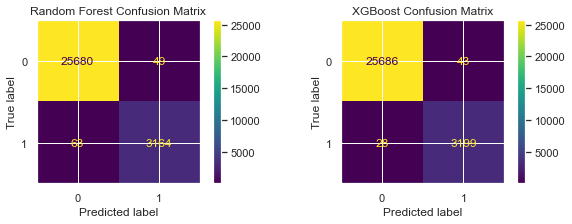

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
#Confusion Matrix Random Forest
ConfusionMatrixDisplay.from_estimator(rf, X_val_tfidf_rf, y_val1, ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
#Confusion Matrix Boost
ConfusionMatrixDisplay.from_estimator(boost, X_val_tfidf_boost, y_val1, ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix')

#classification report for Random Forest
print("###### CLASSIFICATION REPORT FOR RANDOM FOREST #######")
y_pred = rf.predict(X_val_tfidf_rf)
print(classification_report(y_val1, y_pred))

#classification report for Boost
print("###### CLASSIFICATION REPORT FOR XGBOOST ######")
y_pred = boost.predict(X_val_tfidf_boost)
print(classification_report(y_val1, y_pred))


The classification reports for both models are looking like we are achieving very high levels of recall and precision for both of our classes 1 (trending) and 0 (non-trending) with XGBoost performing 1% better with regards to predicting trending class one. How is this reflected in the confusion matrices? Something to pay attention to here is the False Negatives and False Positives whereby both models have very low absolute numbers of these at less than 2%, but that Random Forest has a higher level of False Positives than False Negatives and XGBoost has the inverse relationship. 

Which one is better? If we think about our end goal for this project the user of the model wants to be able to predict trending beauty products, so let's consider two scenarios. Would the user rather have variety and range of predictions and see more false positives that aren't truly trending products or would we want to have more concise trend predictions and have more products go undetected? We would probably want a balance of the two but have a higher false positive rate than false negative rate, but these numbers are very little between the models, so it will come down to model interpretability. 

### <font color='256D85'> Deciding between Random Forest and XGBoost <font> <a id="4.a"></a>

After having seen the confusion matrices, the classification reports, and the final hyper-parameters for our model how we can decide between Random Forest and XGBoost models when they have very similar model scores? Something that is important here is interpretability, and being able to define what are the most important features in the model. The end user of this model is aimed at a stakeholder in the innovation or marketing department of a company, so keeping the final model as simple as possible is the goal. This is why ultimately we will select Random Forest for 2 key reasons: 
1. Random Forest models are easier to interpret and explain compared to XGBoost models. Since Random Forest models use decision trees, we can easily understand how the model makes decisions by looking at the decision paths but XGboost requires more understanding. 
2. After having evaluated the hyper-parameters of our model there was a slight concern of XGBoost having over fitted predictions to the training set based on its hyper-parameters, the concern is there also for Random Forest but we have a higher level of confidence that it is less sensitive to outliers. 

The Random Forest Model has been selected as our model for the project. We are still slightly concerned that it is over fitting slightly to the training data, but we can start by looking at the most important features. 

### <font color='256D85'> Random Forest Interpretability <font> <a id="4.b"></a>

A way to interpret the model chosen is through looking at its Feature Importance which gives a score for all of the given input features for the model. Below since we have 126 columns in our model we will evaluate the Top 15 features. 

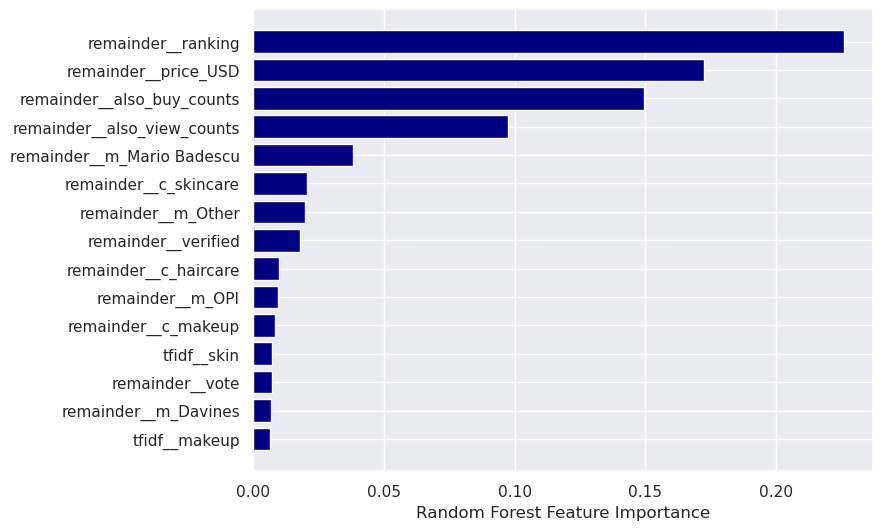

In [81]:
#feature importance plot
sorted_idx = rf.feature_importances_.argsort() #sorted
top15_sorted_idx = rf.feature_importances_.argsort()[-15:] #sorting by top 15
plt.barh(ct_train_rf.get_feature_names_out()[top15_sorted_idx ], rf.feature_importances_[top15_sorted_idx ], color ='navy')
plt.xlabel("Random Forest Feature Importance")
plt.show()

The way we can interpret the plot above is that the higher the value, the more important the feature is to predict the target variable. Here we can see some interesting insights: 
- Ranking has the largest importance in the model, this makes sense so now we know that ranking influences the increasing review counts, we did check the correlations between our target and this column and they weren't highly correlated with each other to begin with. 
- The Tf-idf Vectorizer picked up similar points to what our feature engineering did in terms of skincare, make-up where skincare brands such as Mario Badescu played a role in indicating its trendiness. 
- `price`, `also_view_counts` and `also_buy_counts` all played a fairly large part in driving the results of the model, indicating that trending products are more sensitive to price and mentions in other product listings. 

It may be worth to note that the feature_importances output can be a bit misleading as it tends to inflate the importances for the continuous features or features with many unique categorical values.

#### Can we make any model improvements? 

In the previous section we described how our final Random Forest model is most likely over fitting with a 99.94% F1-micro score. Therefore, we want to make our final model more regularized. We can do so by adjusting the hyper-parameters slightly and we are also interested in vectorizing both of the `reviewText` and `product_description` columns, however this may come at the cost of having more features. 

### <font color='256D85'> Applying the machine learning algorithm with product description <font> <a id="4.c"></a>

In this next section, we will be applying the Random Forest algorithm on our second model (including product description) and another GridSearchCV with restricted hyper-parameter features to make the model more generalized to capture more false positives. We can adjust the column transformer and define the parameters for the grid search. 

#### Defining our columns

In [16]:
#for Train test split
from sklearn.model_selection import train_test_split
y = df_combined["trending_asin"]
remainder2, test2  = train_test_split(df_with_desc, test_size=0.3, stratify= y, random_state = 8)
print(f"Remainder shape {remainder2.shape}")
print(f"Test shape {test2.shape}")

Remainder shape (96519, 62)
Test shape (41366, 62)


In [17]:
#assigning remainder dataset for X and y 
y_remainder2 = remainder2["trending_asin"]
X_remainder2  = remainder2.drop(["trending_asin"],axis=1)

In [18]:
#assigning test dataset for X and y 
y_test2 = test2["trending_asin"]
X_test2  = test2.drop(["trending_asin"],axis=1)

In [19]:
#for train/validation split 
from sklearn.model_selection import train_test_split

X_train2, X_val2, y_train2, y_val2 = train_test_split(X_remainder2, y_remainder2, test_size=0.3, random_state=2, stratify=y_remainder2)
print(f"Train shape {X_train2.shape}")
print(f"Validation shape {X_val2.shape}")

Train shape (67563, 61)
Validation shape (28956, 61)


##### Column Transformer, Pipeline, and Param Grid

In the adjusted column transformer there is a second line for product_description. 

In [20]:
#column transformer
from sklearn.compose import ColumnTransformer


ct_train2 = ColumnTransformer([
        ('r_tfidf', TfidfVectorizer(stop_words="english"), 'reviewText'),
        ('d_tfidf', TfidfVectorizer(stop_words="english"), 'product_description')
    ],
        remainder='passthrough'
)

In [21]:
# Set up a directory to cache the pipeline results
cachedir = mkdtemp()

#pipeline steps according to tranform, pca, scale, 
pipe_rf2 = [('transform', ct_train2),
           ('clf', RandomForestClassifier(n_jobs = 1))]

pipe = Pipeline(pipe_rf2,verbose=4, memory=cachedir)

For the adjusted hyper-parameter grid, there are a couple of things that we want to adjust to produce a more generalized model: 
- **n_estimators**: We can increase the number of trees
- **max_depth**: Decrease the max_depth of each tree so it can prevent the model from overfitting. 
- **min_samples_leaf**: Introduce this feature since setting a higher value for minimum samples per leaf can help prevent overfitting by restricting the tree's ability to fit the noise in the training data.

We also want to save the .csv file of our results so we can evaluate this closer since choosing the best estimator isn't what we are aiming for here. 

In [22]:
rf_param_grid2 = [
    # Random Forest without PCA
    {'transform__r_tfidf__min_df' : [0.03],
     'transform__r_tfidf__max_features': [200],
     'transform__d_tfidf__min_df' : [0.03,0.4],
     'transform__d_tfidf__max_features': [500],
     'clf': [RandomForestClassifier(n_jobs = 1)],
     'clf__max_depth': [20,25,30],
     'clf__n_estimators':[500,600,700],
     'clf__min_samples_leaf' : [1]
     }
]

In [23]:
#more refined grid search to total train set 
rf_gs2 = GridSearchCV(estimator = pipe, 
                    param_grid = rf_param_grid2, 
                    cv=5, 
                    n_jobs=1,
                    verbose = 4,
                    refit=True,
                    scoring = 'f1_micro')

fitted_rf_gs2 = rf_gs2.fit(X_remainder2, y_remainder2)

grid_search_results = fitted_rf_gs2.cv_results_

best_estimator = fitted_rf_gs2.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


divide by zero encountered in true_divide


[Pipeline] ......... (step 1 of 2) Processing transform, total=  11.5s


Persisting input arguments took 0.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.2min
[CV 1/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=500, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.03, transform__r_tfidf__max_features=200, transform__r_tfidf__min_df=0.03;, score=0.983 total time= 1.5min


divide by zero encountered in true_divide


[Pipeline] ......... (step 1 of 2) Processing transform, total=  11.5s


Persisting input arguments took 0.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.2min
[CV 2/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=500, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.03, transform__r_tfidf__max_features=200, transform__r_tfidf__min_df=0.03;, score=0.985 total time= 1.5min


divide by zero encountered in true_divide


[Pipeline] ......... (step 1 of 2) Processing transform, total=  11.6s


Persisting input arguments took 0.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.2min
[CV 3/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=500, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.03, transform__r_tfidf__max_features=200, transform__r_tfidf__min_df=0.03;, score=0.982 total time= 1.5min


divide by zero encountered in true_divide


[Pipeline] ......... (step 1 of 2) Processing transform, total=  11.6s


Persisting input arguments took 0.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.2min
[CV 4/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=500, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.03, transform__r_tfidf__max_features=200, transform__r_tfidf__min_df=0.03;, score=0.985 total time= 1.5min


divide by zero encountered in true_divide


[Pipeline] ......... (step 1 of 2) Processing transform, total=  11.6s


Persisting input arguments took 0.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.2min
[CV 5/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=500, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.03, transform__r_tfidf__max_features=200, transform__r_tfidf__min_df=0.03;, score=0.983 total time= 1.5min


divide by zero encountered in true_divide


[Pipeline] ......... (step 1 of 2) Processing transform, total=  11.2s


Persisting input arguments took 0.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.0min
[CV 1/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=500, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.4, transform__r_tfidf__max_features=200, transform__r_tfidf__min_df=0.03;, score=0.974 total time= 1.3min


divide by zero encountered in true_divide


[Pipeline] ......... (step 1 of 2) Processing transform, total=  11.1s


Persisting input arguments took 0.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[Pipeline] ............... (step 2 of 2) Processing clf, total=  51.1s
[CV 2/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=500, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.4, transform__r_tfidf__max_features=200, transform__r_tfidf__min_df=0.03;, score=0.978 total time= 1.1min


divide by zero encountered in true_divide


[Pipeline] ......... (step 1 of 2) Processing transform, total=  11.3s


Persisting input arguments took 0.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[Pipeline] ............... (step 2 of 2) Processing clf, total=  46.2s
[CV 3/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=500, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.4, transform__r_tfidf__max_features=200, transform__r_tfidf__min_df=0.03;, score=0.974 total time= 1.1min
[Pipeline] ......... (step 1 of 2) Processing transform, total=  11.2s


Persisting input arguments took 0.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[Pipeline] ............... (step 2 of 2) Processing clf, total=  49.6s
[CV 4/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=500, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.4, transform__r_tfidf__max_features=200, transform__r_tfidf__min_df=0.03;, score=0.977 total time= 1.1min


divide by zero encountered in true_divide


[Pipeline] ......... (step 1 of 2) Processing transform, total=  11.1s


Persisting input arguments took 0.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[Pipeline] ............... (step 2 of 2) Processing clf, total=  46.6s
[CV 5/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=500, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.4, transform__r_tfidf__max_features=200, transform__r_tfidf__min_df=0.03;, score=0.975 total time= 1.1min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.4min
[CV 1/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=600, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.03, transform__r_tfidf__max_features=200, transform__r_tfidf__min_df=0.03;, score=0.984 total time= 1.5min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.4min
[CV 2/5] END clf=RandomForestClassifier(n_jobs=1), clf__max_depth=20, clf__min_samples_leaf=1, clf__n_estimators=600, transform__d_tfidf__max_features=500, transform__d_tfidf__min_df=0.03, transform__r_tf

divide by zero encountered in true_divide


[Pipeline] ......... (step 1 of 2) Processing transform, total=  14.4s


Persisting input arguments took 1.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.5min


In [24]:
#calling the save function
write_results_to_s3(grid_search_results, 'rf_results_model_2.csv', 'deliverable-slo-bstn-bucket', 'rf_results_model_2.csv')

rf_results_model_2.csv has been saved to deliverable-slo-bstn-bucket


After having analyzed the results from the csv file we will apply some more generalized hyper parameters to the model.

In [30]:
#column transformer
from sklearn.compose import ColumnTransformer


ct_train2 = ColumnTransformer([
        ('r_tfidf', TfidfVectorizer(stop_words="english",min_df=0.03,max_features=1000), 'reviewText'),
        ('d_tfidf', TfidfVectorizer(stop_words="english",min_df=0.04,max_features=1000), 'product_description')
    ],
        remainder='passthrough'
)

# 2. Fit 
ct_train2.fit(X_train2,y_train2)

# 3. Transform
X_train_tfidf_rf2 = ct_train2.transform(X_train2)
X_val_tfidf_rf2 = ct_train2.transform(X_val2)
X_test_tfidf_rf2 = ct_train2.transform(X_test2)
print(f"Shape of the output after vectorization is: {X_train_tfidf_rf2.shape}")

divide by zero encountered in true_divide


Shape of the output after vectorization is: (67563, 657)


The shape output of model two isn't looking the best at 657 columns, this may make the model too complex and actually cause over-fitting which is not what we intended to do. Let's plot this out with a confusion matrix.

In [31]:
#instantiate the model
rf = RandomForestClassifier(n_estimators = 500, 
                            max_features = 0.2, 
                            max_depth = 25
)
#fit
rf.fit(X_train_tfidf_rf2, y_train2)

RandomForestClassifier(max_depth=25, max_features=0.2, n_estimators=500)

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

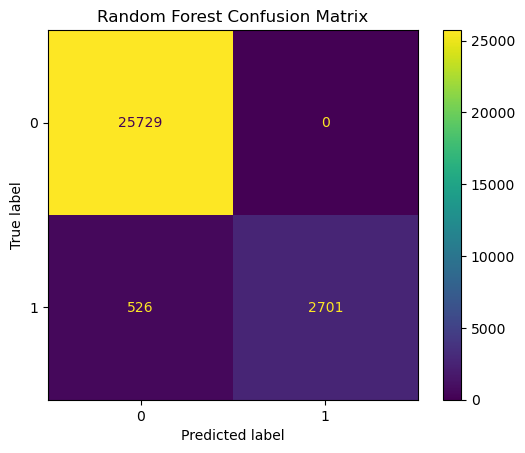

In [33]:
#Confusion Matrix Random Forest
ConfusionMatrixDisplay.from_estimator(rf, X_val_tfidf_rf2, y_val2)
plt.title('Random Forest Confusion Matrix')

From taking a look at the confusion matrix we can clearly see that we have no false positives and worse results in general, in fact making the model more complex by adding in the product description column makes performance worse. Sometimes it's better to stick with your first model and keep things more simple. 

### <font color='256D85'> The Final Model <font> <a id="4.d"></a>

After having taken a mini detour with model 2 we can now evaluate our original model which is our model which just contains the `reviewText` column. To finish let's evaluate our model against the test set that we've reserved for the very end.

In [87]:
#count vectorizer function
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import  TfidfVectorizer

ct_train_rf = ColumnTransformer([
        ('tfidf', TfidfVectorizer(stop_words="english",min_df=0.03,max_features=1000), 'reviewText')
    ],
    remainder='passthrough'
)

# 2. Fit 
ct_train_rf.fit(X_train1,y_train1)

# 3. Transform
X_train_tfidf_rf = ct_train_rf.transform(X_train1)
X_val_tfidf_rf = ct_train_rf.transform(X_val1)
X_test_tfidf_rf = ct_train_rf.transform(X_test1)
print(f"Shape of the output after vectorization is: {X_train_tfidf_rf.shape}")

divide by zero encountered in true_divide


Shape of the output after vectorization is: (67563, 126)


###### CLASSIFICATION REPORT FOR RANDOM FOREST MODEL 1 #######
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36756
           1       0.98      0.98      0.98      4610

    accuracy                           1.00     41366
   macro avg       0.99      0.99      0.99     41366
weighted avg       1.00      1.00      1.00     41366



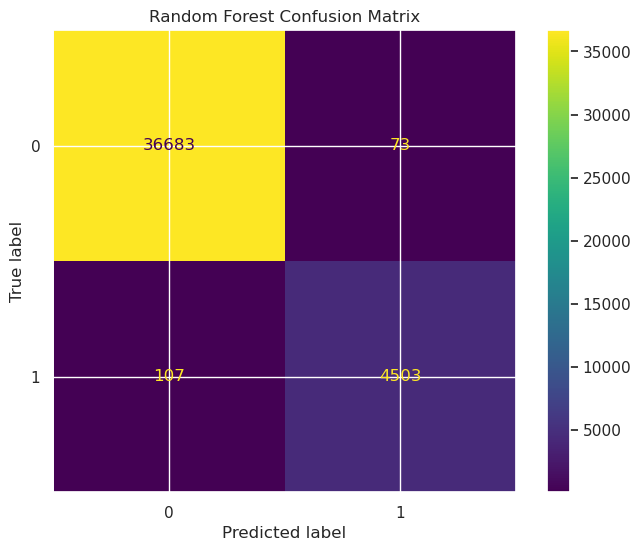

In [86]:
#Final Matrix Random Forest
ConfusionMatrixDisplay.from_estimator(rf, X_test_tfidf_rf, y_test1)
plt.title('Random Forest Confusion Matrix')

#classification report for Random Forest
print("###### CLASSIFICATION REPORT FOR RANDOM FOREST MODEL 1 #######")
y_pred = rf.predict(X_test_tfidf_rf)
print(classification_report(y_test1, y_pred))

These numbers are looking pretty good against the test set, we achieved a 98% F1-micro score against our target column! So the fears of over-fitting didn't come to fruition, we still have a higher number of false negatives than positives, but these are fairly balanced still, what is great is that all of the feature engineering and cleaning we did at the start of this notebook seemed to pay off when it came to modelling. Let's summarize our final model parameters below.

| **Final Model** | **F1-Micro Score on Test (Trending)** | **Best Parameters TFIDF**          | **Best Parameters Model**                                 |
|-----------------|-----------------------------|------------------------------------|-----------------------------------------------------------|
| Random Forest       | 98%                      | [min_df=0.03, max_features = 1000] | [n_estimators = 500, max_depth = 40 , max_features = 0.2] |
| Baseline        | 89%                      | -------------------                | ------------------------                                  |

##  <font color='256D85'> Conclusion to this notebook <font> <a id="5"></a>

Throughout this notebook, we have explored four different machine learning algorithms and evaluated the best two models by using confusion matrices and feature importance. Finally, we tried to make the model more generalizable by performing some hyper-parameter tuning but we learned that sometimes the first model is the best. 

### <font color='256D85'> Final Thoughts on the project <font> <a id="5.a"></a>

The main goal of this project was to create a Trend Searcher at the product level, since it could bring a greater level of proof for companies or stakeholder working in new product development or advertising. Personally, I think that we accomplished the needs for this project by predicting which products were trending so I would be excited to apply this (with some new hyper-parameter tuning) to fresh data. Some next steps that I would want to incorporate are to: 

- Add more evaluation metrics such as the shapley value to see if this would improve the result
- Remove the ranking feature and discover if the model can produce accurate results without this value. Although it is an intuitive metric to play larger feature importance, this was only found at the very end of the modelling process. 

Thank you for taking the time to read through this project, I truly enjoyed the entire process and personally learnt a great deal (whilst also having dedicated time to carry out side research on some skincare brands!). 